In [45]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
from scipy.optimize import curve_fit as cf

files = sorted(glob.glob('Acq*'))  # sorting files according to last 2 digits

In [46]:
# reading file and getting averages for each event in the file
def readData(filename):
    file = open(filename)
    data = file.readlines()

    num_samples = int(data[2].strip().split(" ")[-1])
    num_events = 0

    averages = np.zeros(num_samples)  # will replace 0s with data later

    for line in data:
        if line[:5] == "Event":
            num_events += 1

    num_events -= 1  # disregarding last event because of corrupt data

    df = pd.read_csv(filename, skiprows=4, delimiter='\t', lineterminator='\n', header=0, on_bad_lines='warn', usecols=['CH: 0'], low_memory=False)
    df2 = df[df['CH: 0'] != 'CH: 0']
    df2 = df2['CH: 0'].to_numpy(dtype=float)  # changing pandas series to numpy array with float values

    for event in range(num_events):
        voltage = df2[num_samples * event:(num_samples) + num_samples * event]

        if not np.isnan(voltage).any():  # disregarding any nan values in dataset
            averages += voltage

    file.close()

    return averages / num_events, num_events, num_samples

In [47]:
# sine function fit
def sine_func(t, a, b, c, d):
    return a * np.sin((b * t) + d) + c

# gaussian function fit
def gauss_func(t, amp, mean, sigma):
    return amp * np.exp(-0.5 * ((t - mean) / sigma) ** 2)

In [48]:
# data parameters
reclens = [100, 200, 300, 400, 500, 600, 650.016, 700, 750.016, 800, 850.016, 900, 950.016, 1000, 700, 500, 300, 100, 900]
freqs = np.array([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 14, 14, 14, 14, 14, 14]) * (10 ** -3)
ampls = [800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 1000, 1000, 1000, 1000, 1000, 1000]

fits = [True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False]

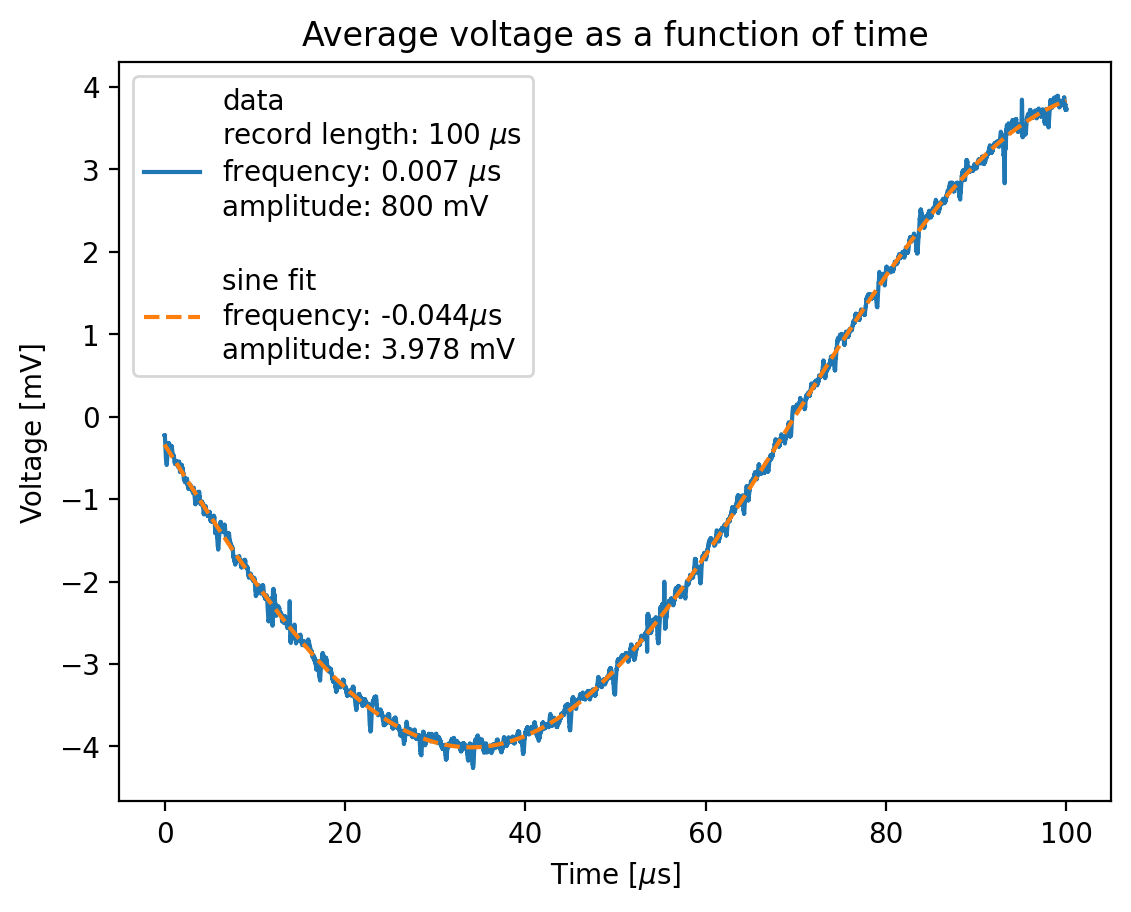

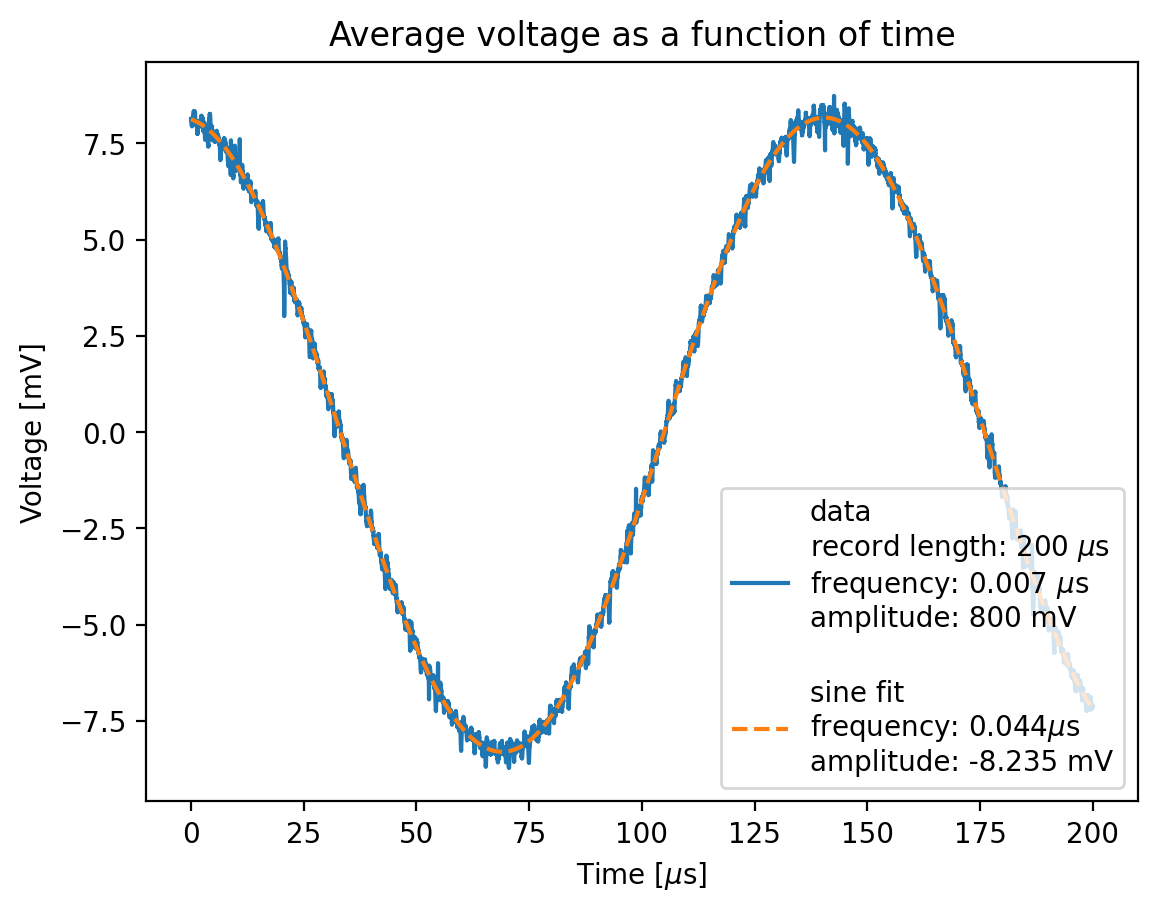

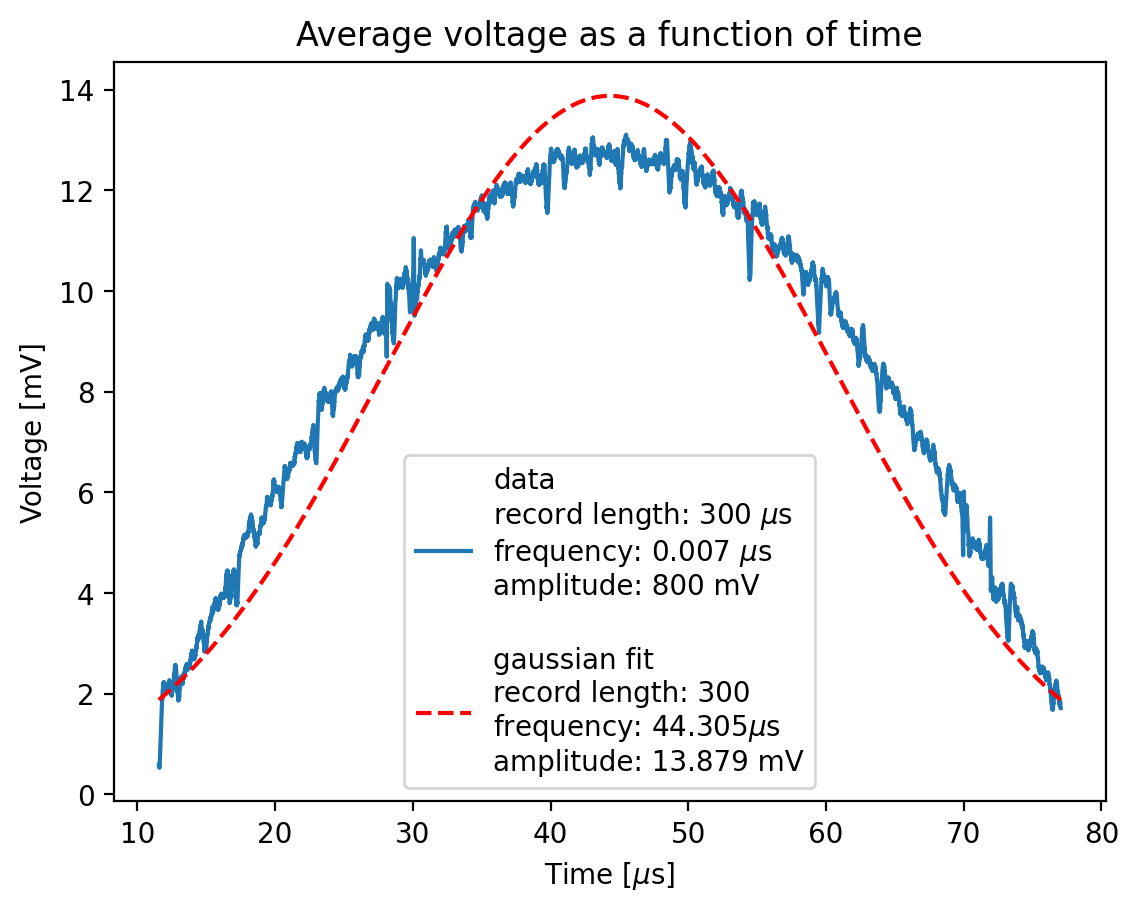

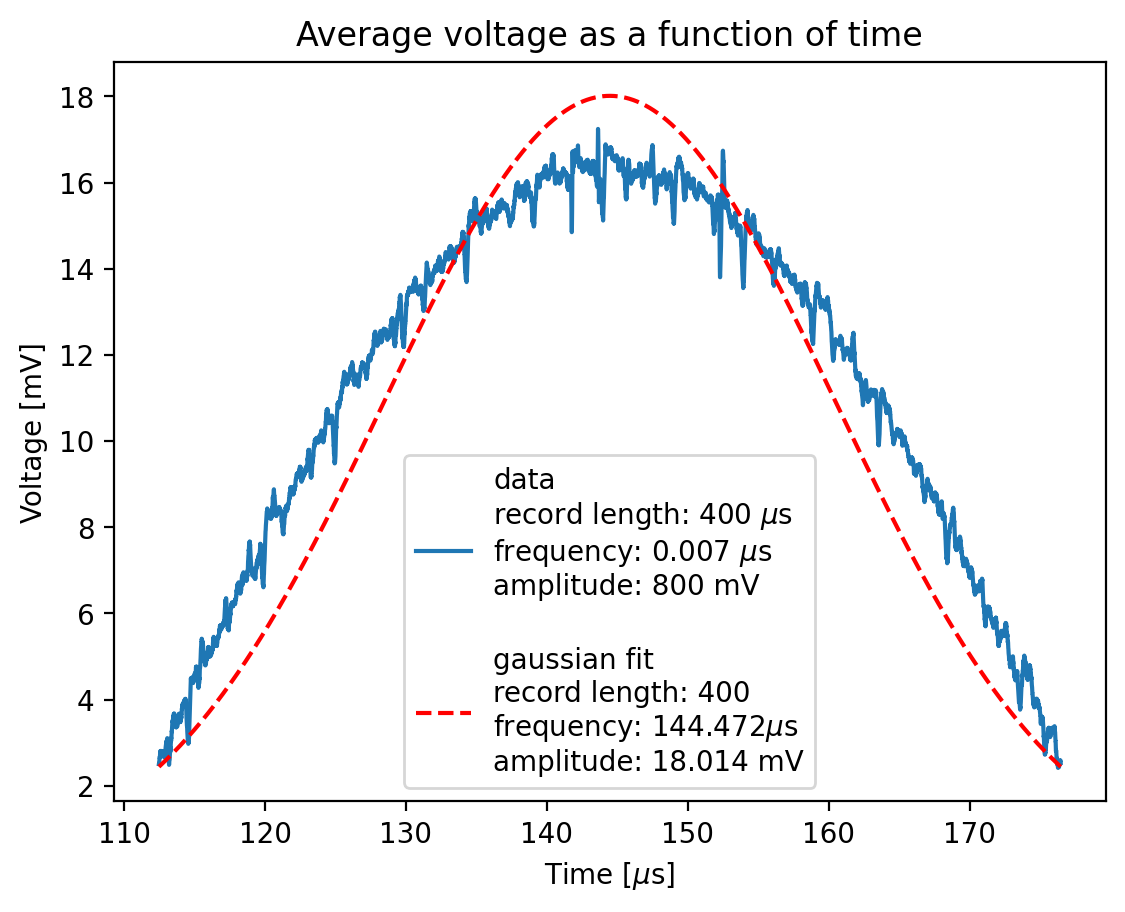

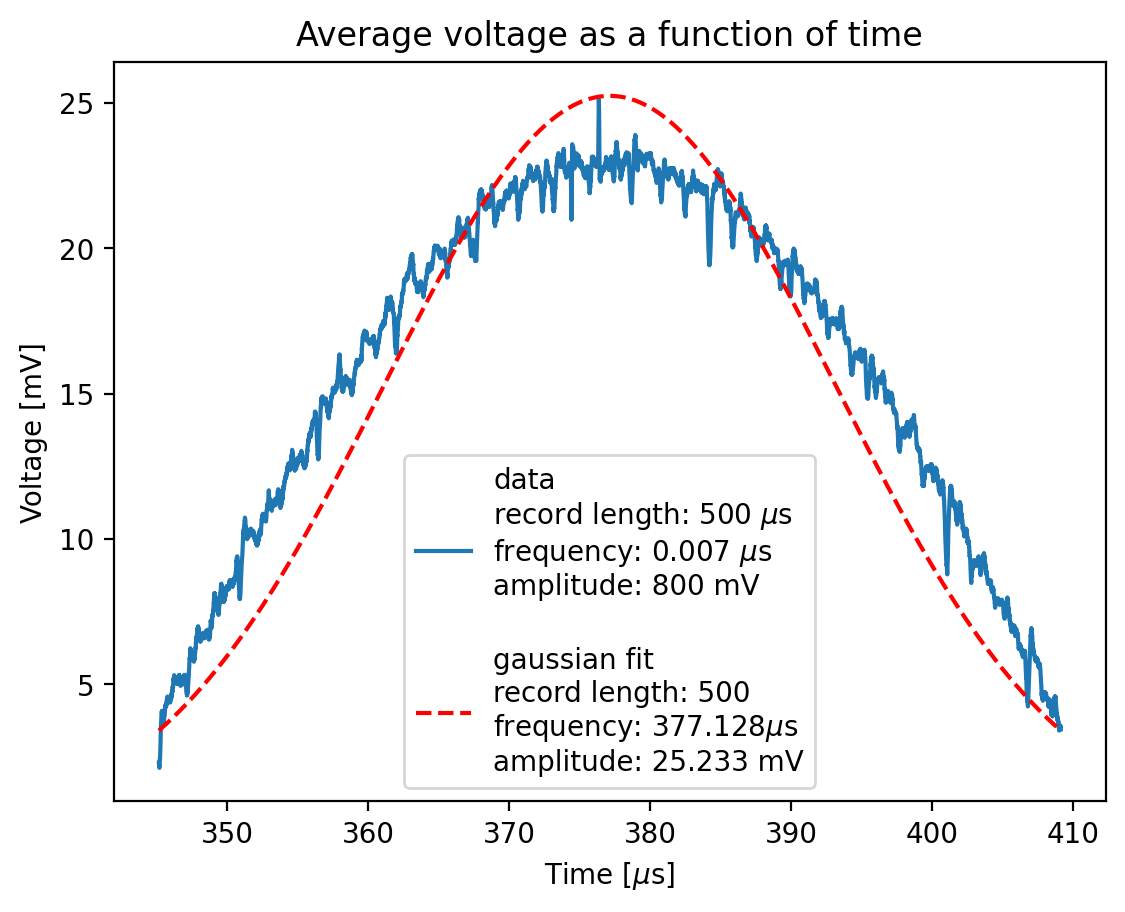

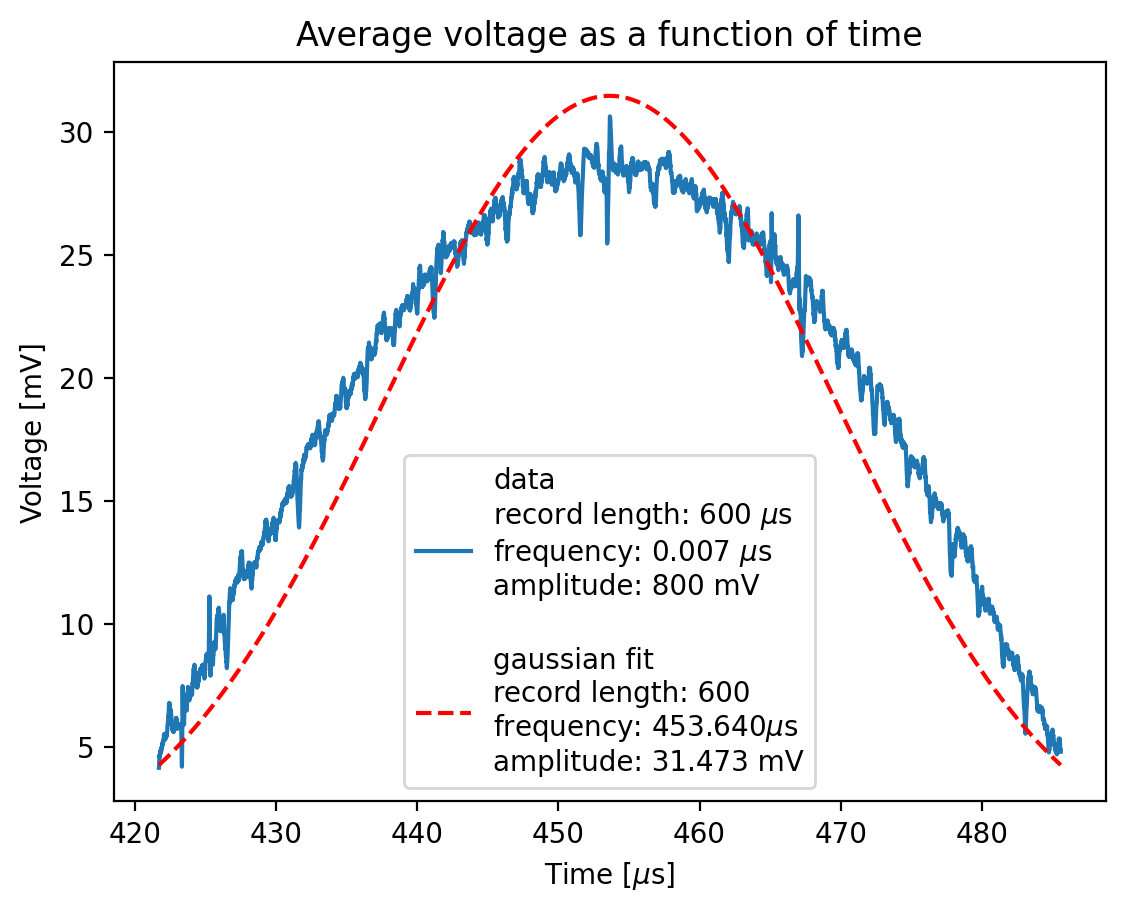

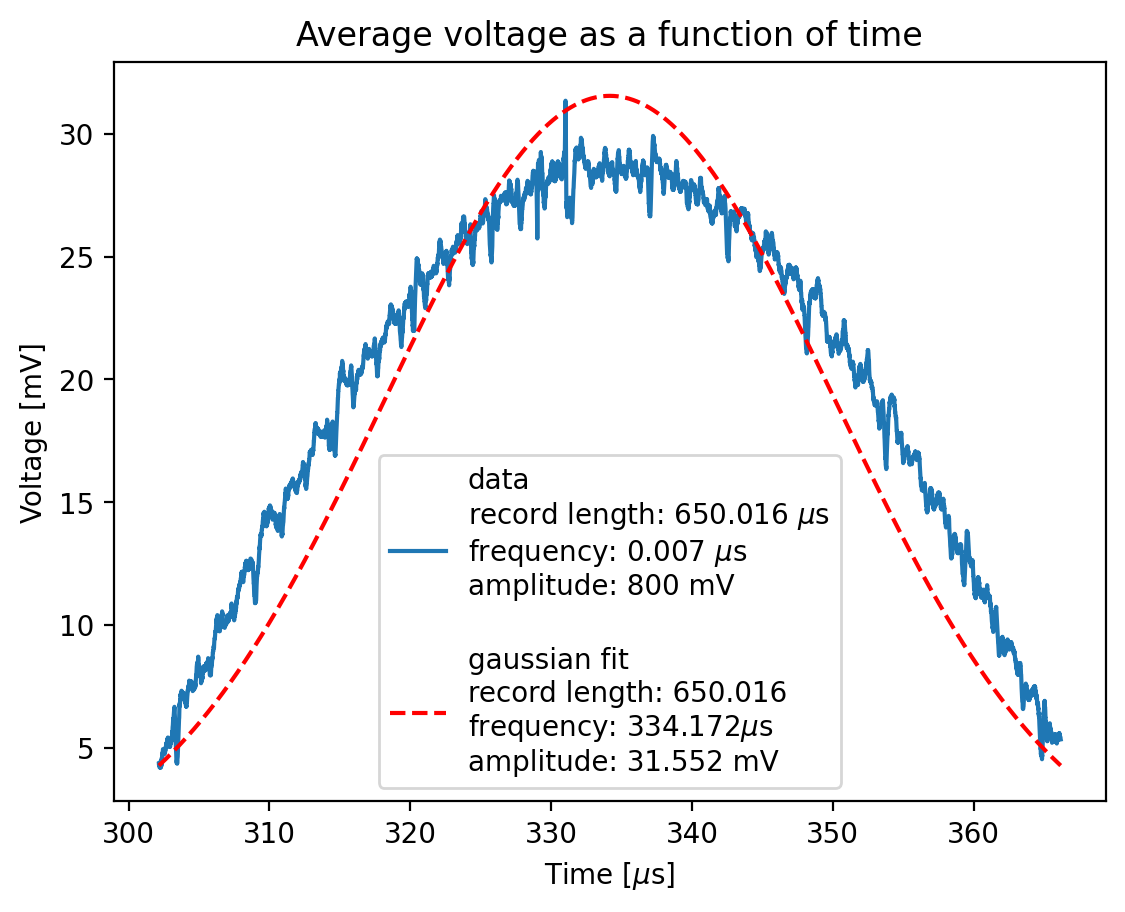

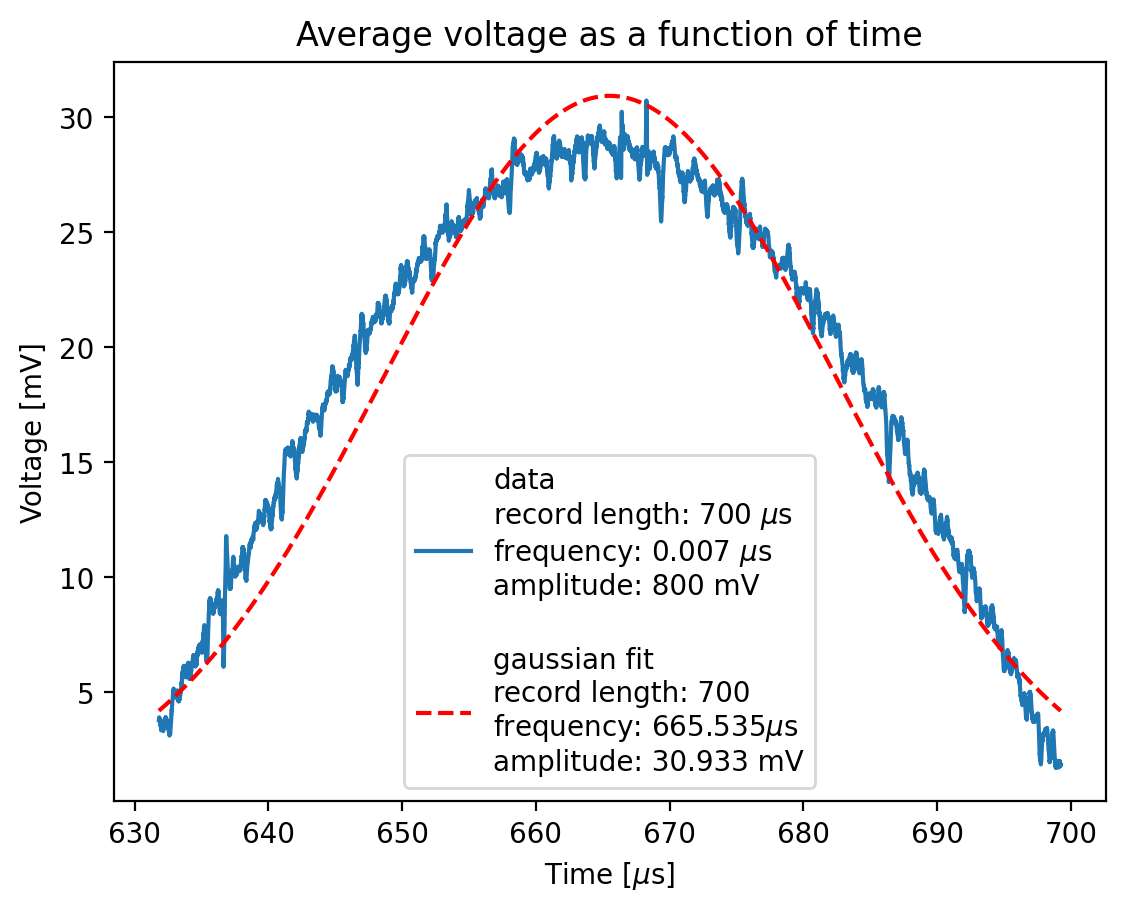

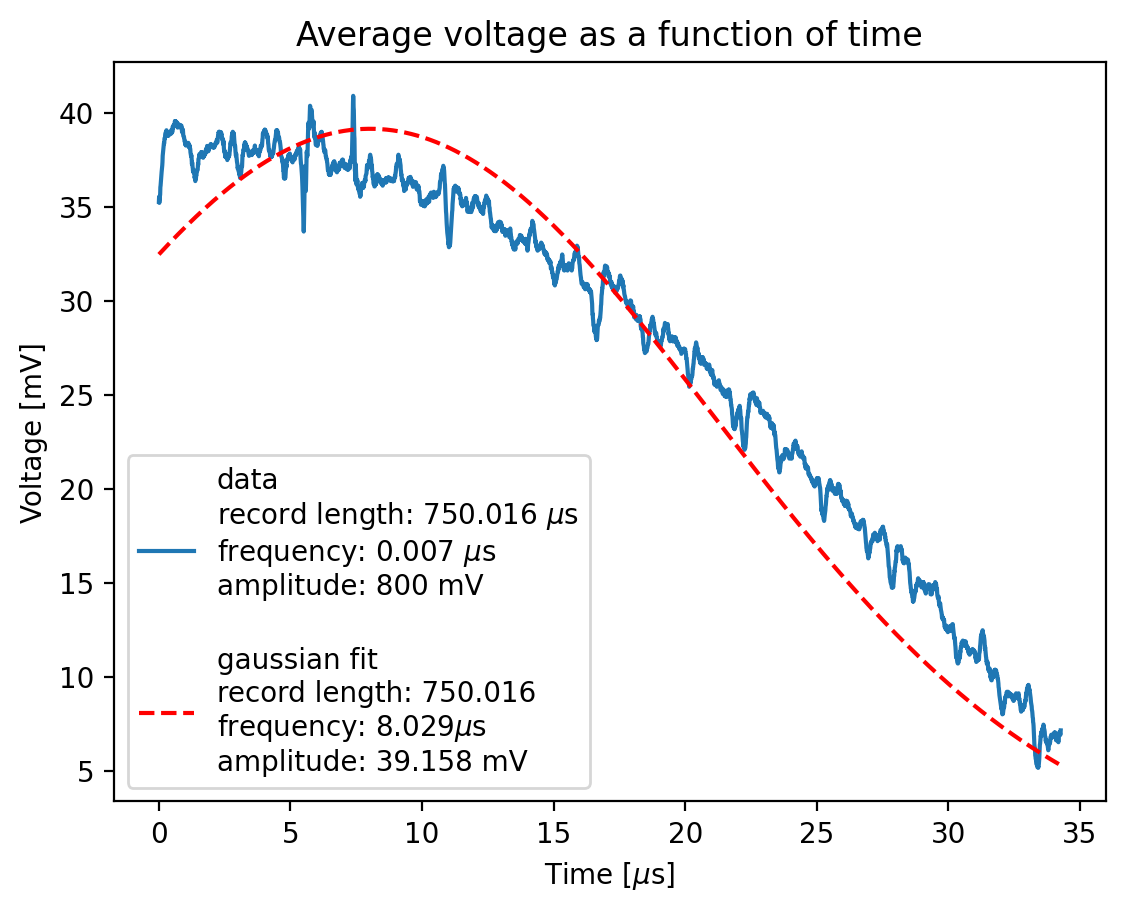

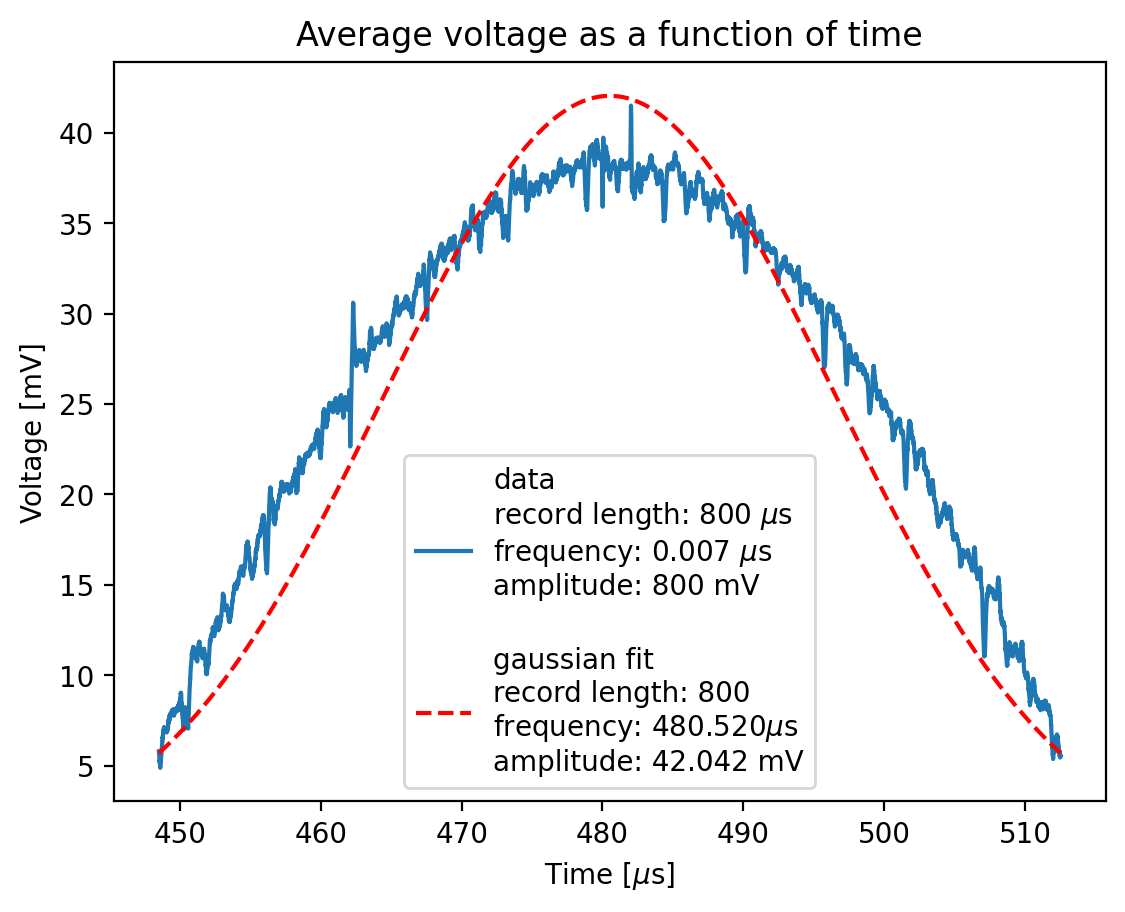

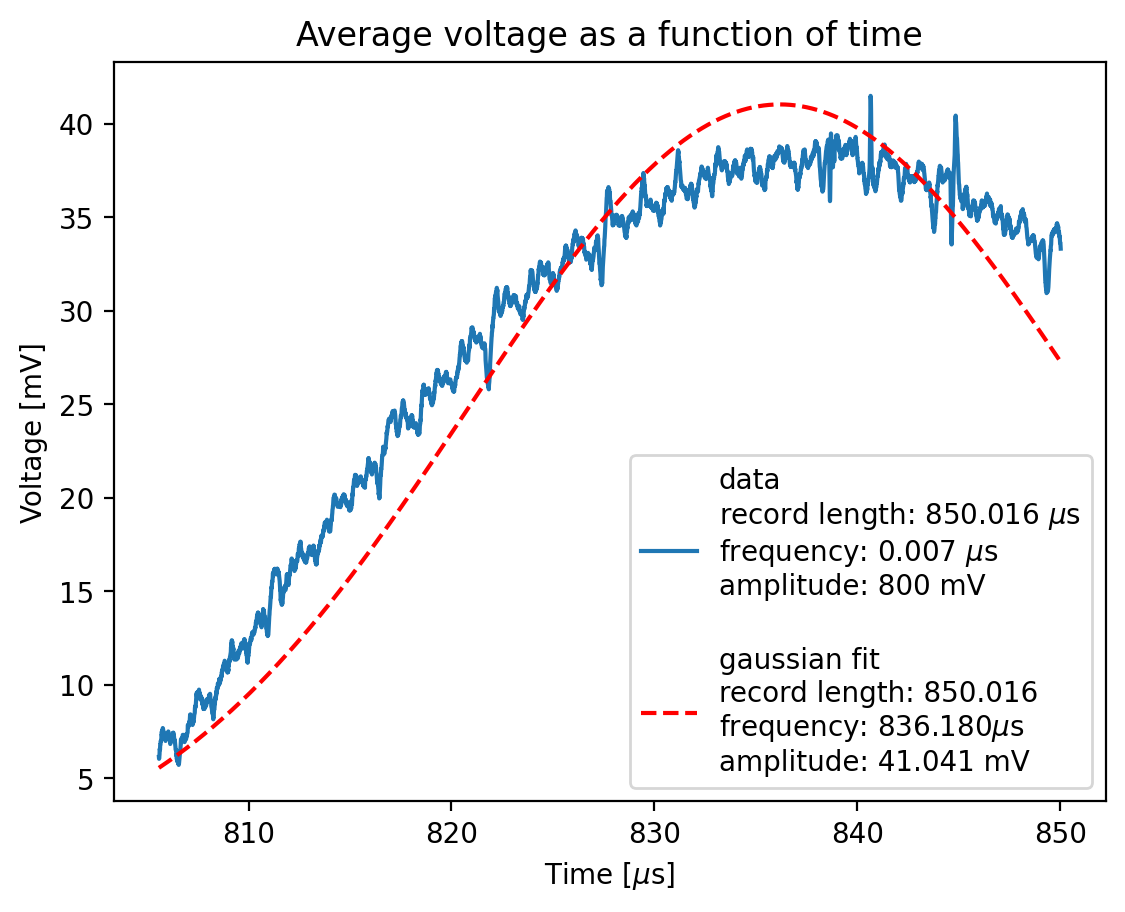

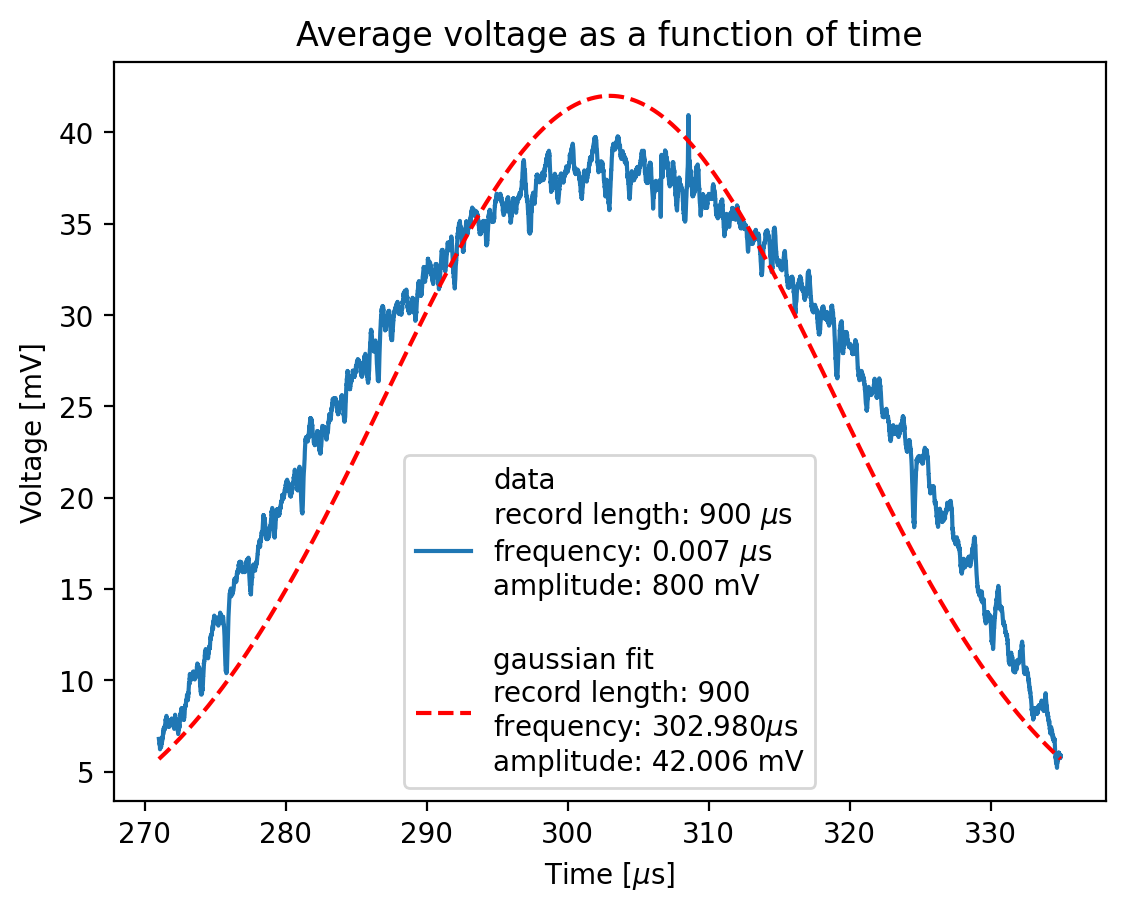

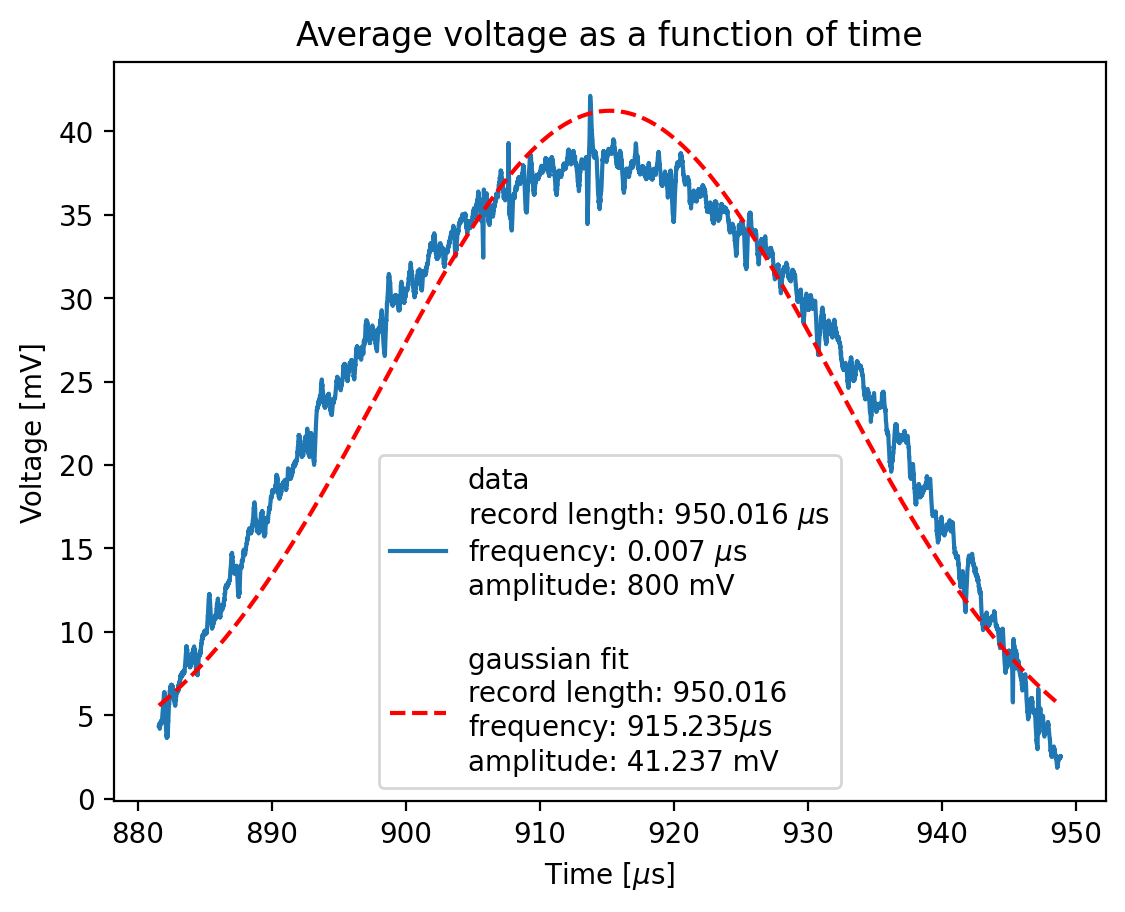

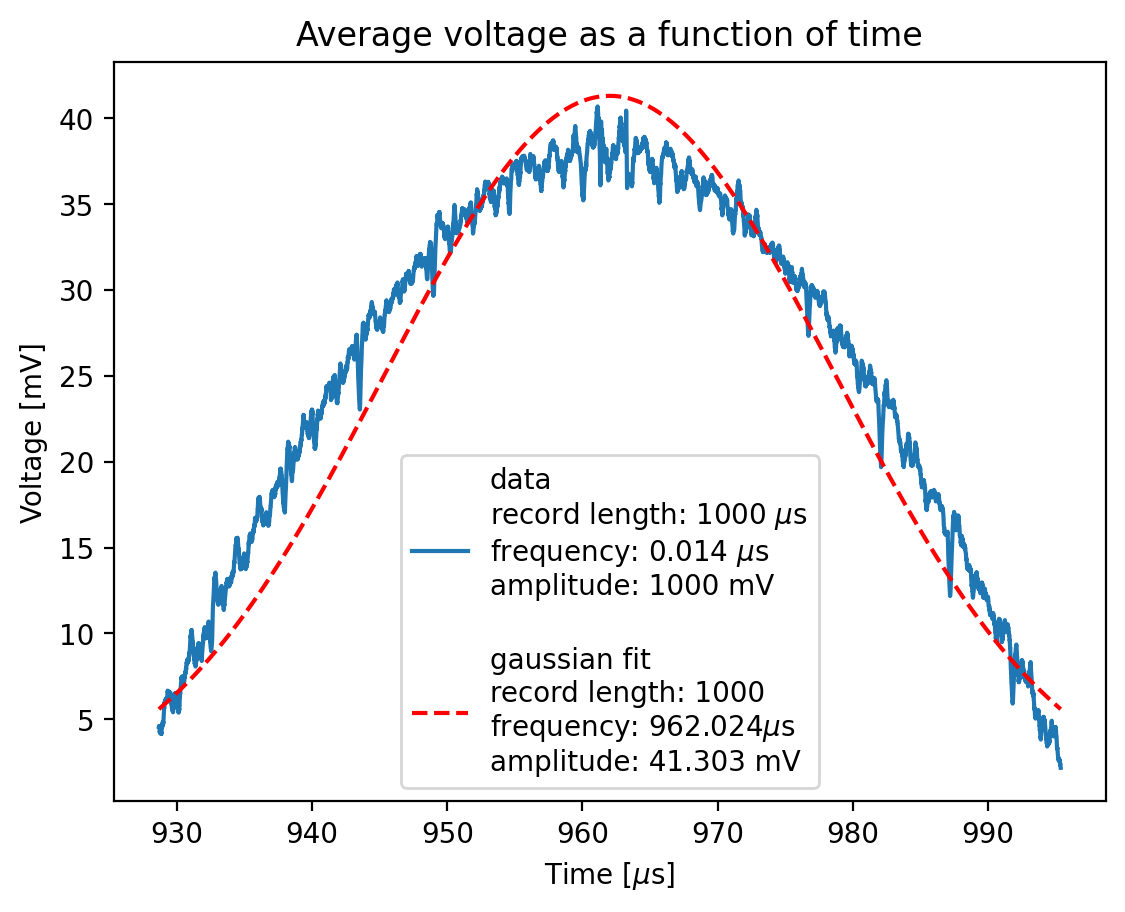

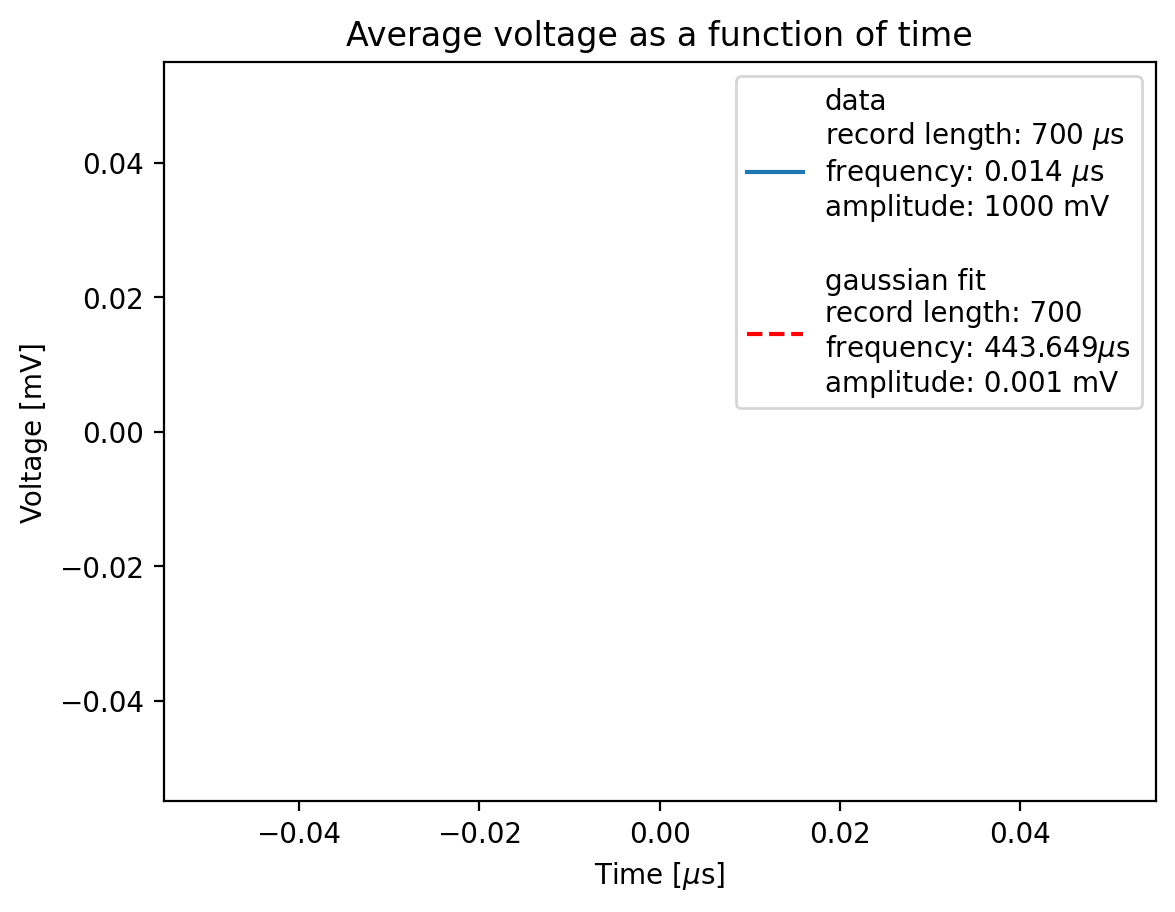

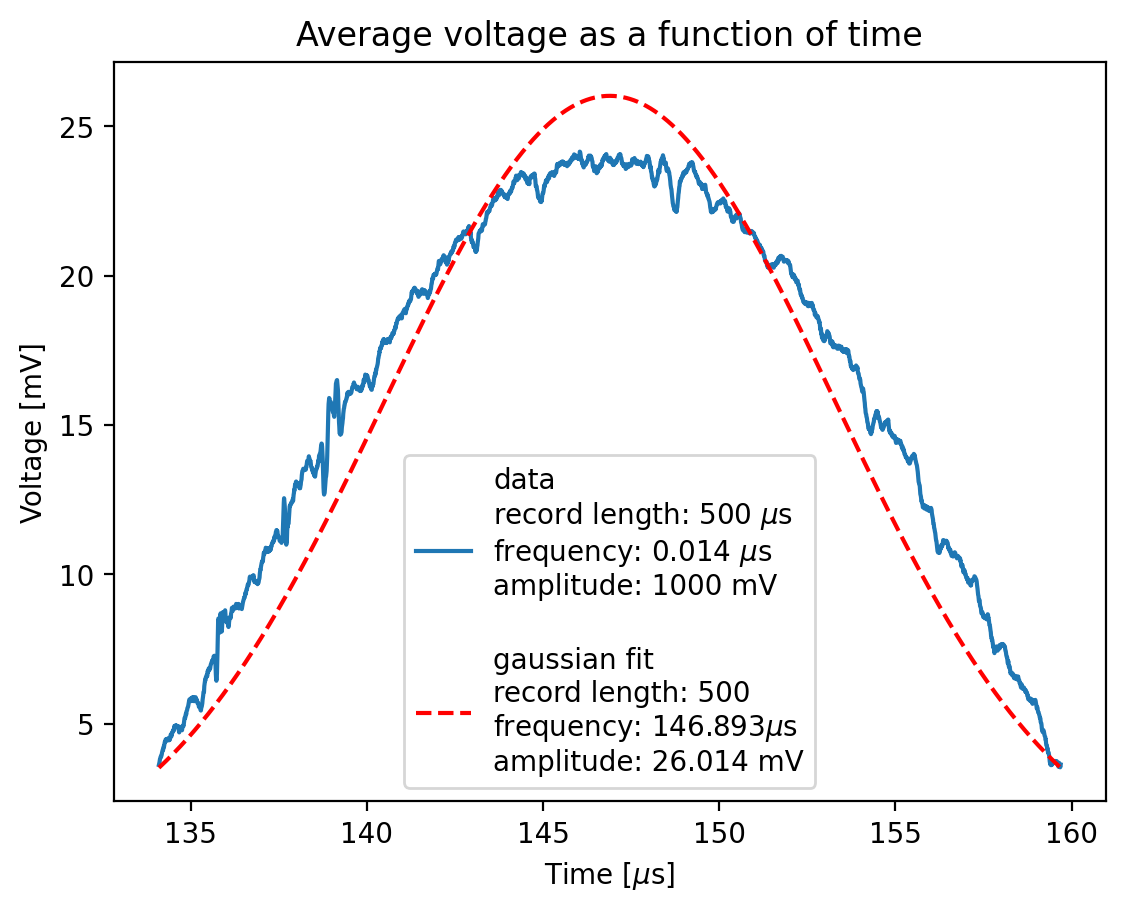

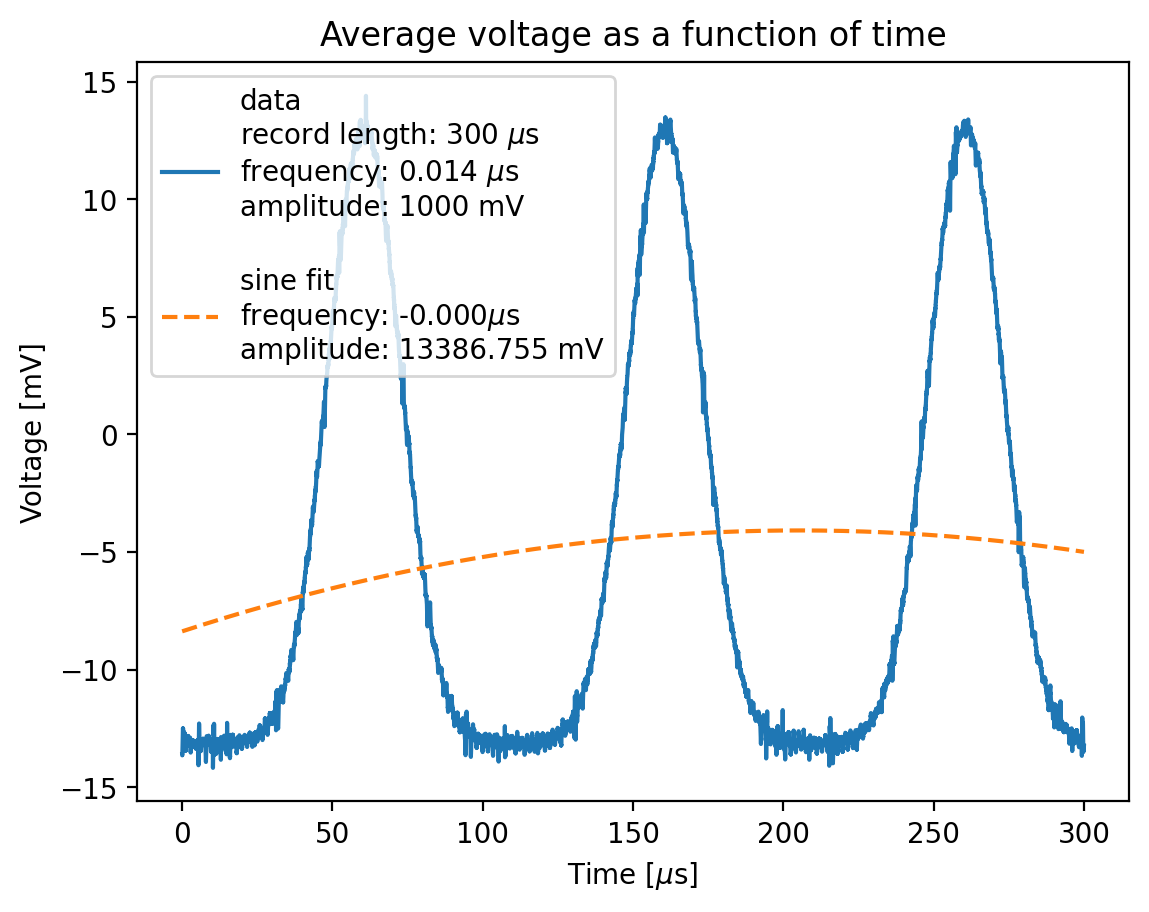

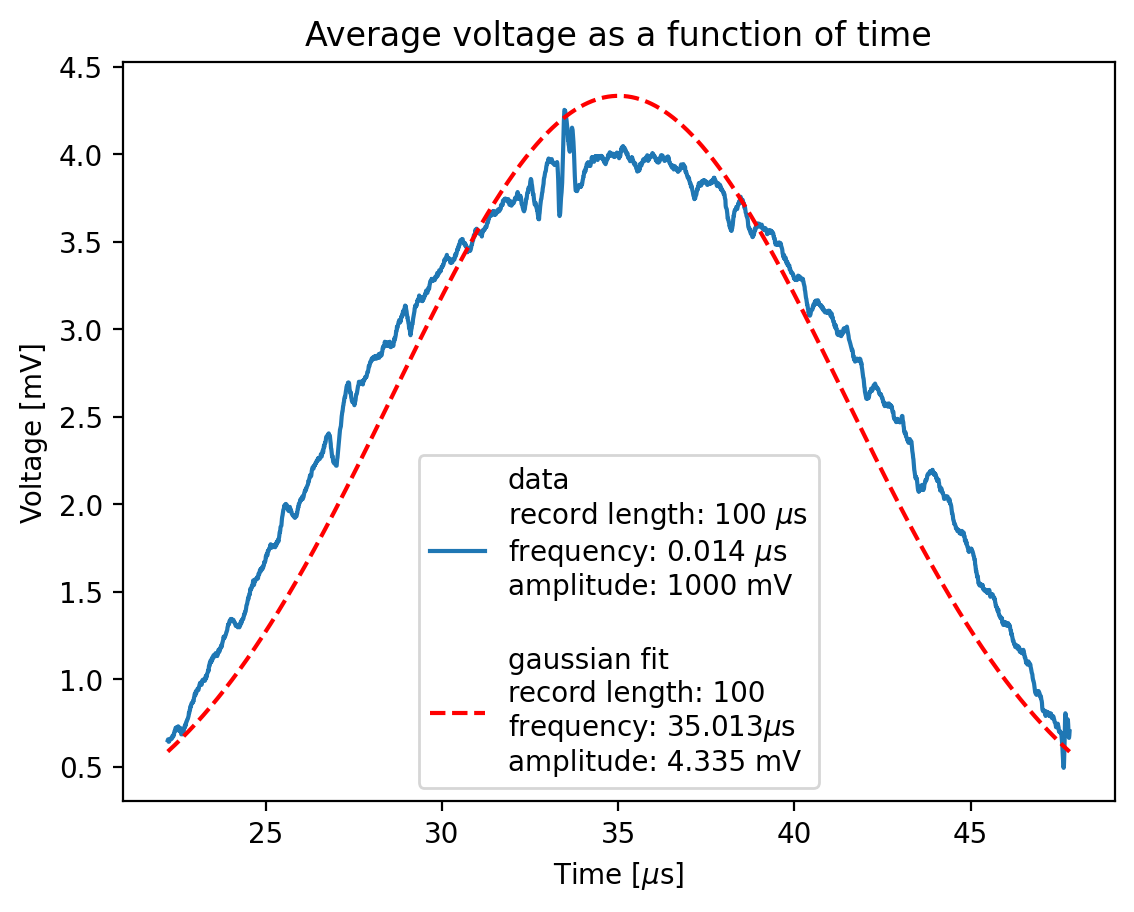

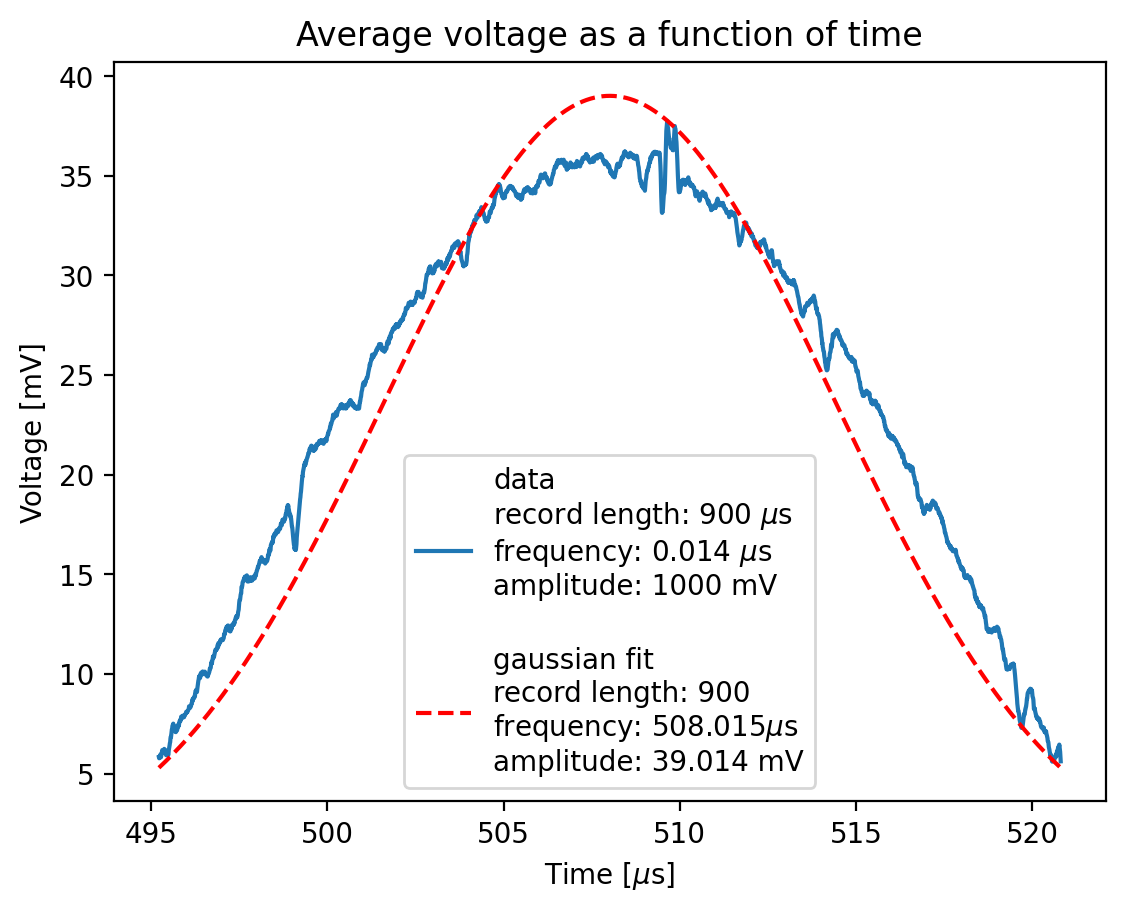

<Figure size 640x480 with 0 Axes>

In [49]:
plt.figure()

for fit, file, reclen, freq, ampl in zip(fits, files, reclens, freqs, ampls):
    averages, num_events, num_samples = readData(file)
    T      = np.linspace(0, reclen, num_samples)
    offset = 3 * np.std(averages) / np.sqrt(2)

    if fit:  # sine wave
        amplitude = (np.max(averages) - np.min(averages)) / 2
        p_opt, p_cov = cf(sine_func, T, averages, p0=[amplitude, freq, offset, 0.5], maxfev=100000)
        fitted_curve = sine_func(T, *p_opt)
        plt.plot(T, averages, label='data\nrecord length: {} $\mu$s\nfrequency: {:.3f} $\mu$s\namplitude: {} mV\n'.format(reclen, freq, ampl))
        plt.plot(T, fitted_curve, '--', label='sine fit\nfrequency: {:.3f}$\mu$s\namplitude: {:.3f} mV'.format(p_opt[1], p_opt[0]))
    
    else:  # gaussian fit
        amplitude = np.max(averages)
        mean      = T[np.argmax(averages)]  # Initial guess for mean
        sigma     = reclen / 6  # Rough estimate for sigma

        # Define bounds for the parameters: amp > 0, mean within T range, sigma > 0
        bounds = ([0, T[0], 0], [np.inf, T[-1], np.inf])

        # Ensure initial guess p0 is within these bounds
        p0 = [amplitude, mean, sigma]
        p_opt, p_cov = cf(gauss_func, T, averages, p0=p0, bounds=bounds, maxfev=100000)

        # Limit T and averages to within ±2 sigma around the mean
        T_fit = T[(T >= (p_opt[1] - 2 * p_opt[2])) & (T <= (p_opt[1] + 2 * p_opt[2]))]
        averages_fit = averages[(T >= (p_opt[1] - 2 * p_opt[2])) & (T <= (p_opt[1] + 2 * p_opt[2]))]
        fitted_curve = gauss_func(T_fit, *p_opt)
        
        plt.plot(T_fit, averages_fit, label='data\nrecord length: {} $\mu$s\nfrequency: {:.3f} $\mu$s\namplitude: {} mV\n'.format(reclen, freq, ampl))
        plt.plot(T_fit, fitted_curve, 'r--', label='gaussian fit\nrecord length: {}\nfrequency: {:.3f}$\mu$s\namplitude: {:.3f} mV'.format(reclen, p_opt[1], p_opt[0]))

    plt.title('Average voltage as a function of time')
    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Voltage [mV]')
    plt.legend()
    plt.show()
    plt.savefig('file_'+file[-6:-4])